In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn import metrics
 
import warnings
warnings.filterwarnings('ignore')
import cryptocompare
import requests
import json
import demjson
from pandas.io.json._normalize import json_normalize
import datetime
from pytrends.request import TrendReq
from pandas_datareader import data as pdr
import yfinance as yfin

import pandas_datareader.data as web
import eventregistry

import praw
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error



# Data Description and Exploration

In [3]:
yfin.pdr_override()
btc_prices = pdr.get_data_yahoo('BTC-USD', start='2014-10-01', end='2023-10-01')
btc_prices
btc_prices.info()
btc_prices.to_csv('btc_prices_df.csv')

[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3287 entries, 2014-10-01 to 2023-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3287 non-null   float64
 1   High       3287 non-null   float64
 2   Low        3287 non-null   float64
 3   Close      3287 non-null   float64
 4   Adj Close  3287 non-null   float64
 5   Volume     3287 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 179.8 KB


In [4]:
btc_prices.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3287.000000,3287.000000,3287.000000,3287.000000,3287.000000,3.287000e+03
mean,14028.967683,14361.846425,13664.405927,14035.717351,14035.717351,1.654436e+10
std,15981.572659,16373.033135,15534.583430,15978.276867,15978.276867,1.930818e+10
min,176.897003,211.731003,171.509995,178.102997,178.102997,5.914570e+06
25%,890.129517,903.933014,846.226501,893.856506,893.856506,1.447430e+08
50%,8037.080078,8216.812500,7830.758789,8041.779785,8041.779785,1.079610e+10
75%,21844.954102,22555.855469,21426.451172,22017.412109,22017.412109,2.720739e+10
max,67549.734375,68789.625000,66382.062500,67566.828125,67566.828125,3.509679e+11


Analyze how prices of the cryptocurrency have moved over the period of time and how the end of the quarters affects the prices of the currency.

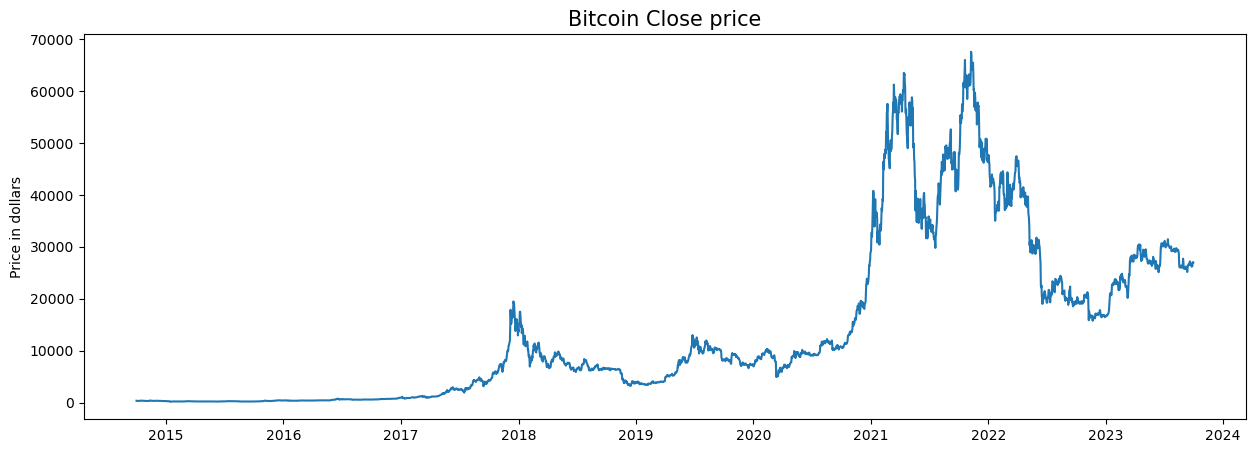

In [5]:
plt.figure(figsize=(15, 5))
plt.plot(btc_prices['Close'])
plt.title('Bitcoin Close price', fontsize=15)
plt.ylabel('Price in dollars')
plt.show()

The prices of the Bitcoin stocks are showing an upward trend as depicted by the plot of the closing price of the stocks

From here we can conclude that all the rows of columns ‘Close’ and ‘Adj Close’ have the same data. So, having redundant data in the dataset is not going to help so, we’ll drop this column before further analysis.

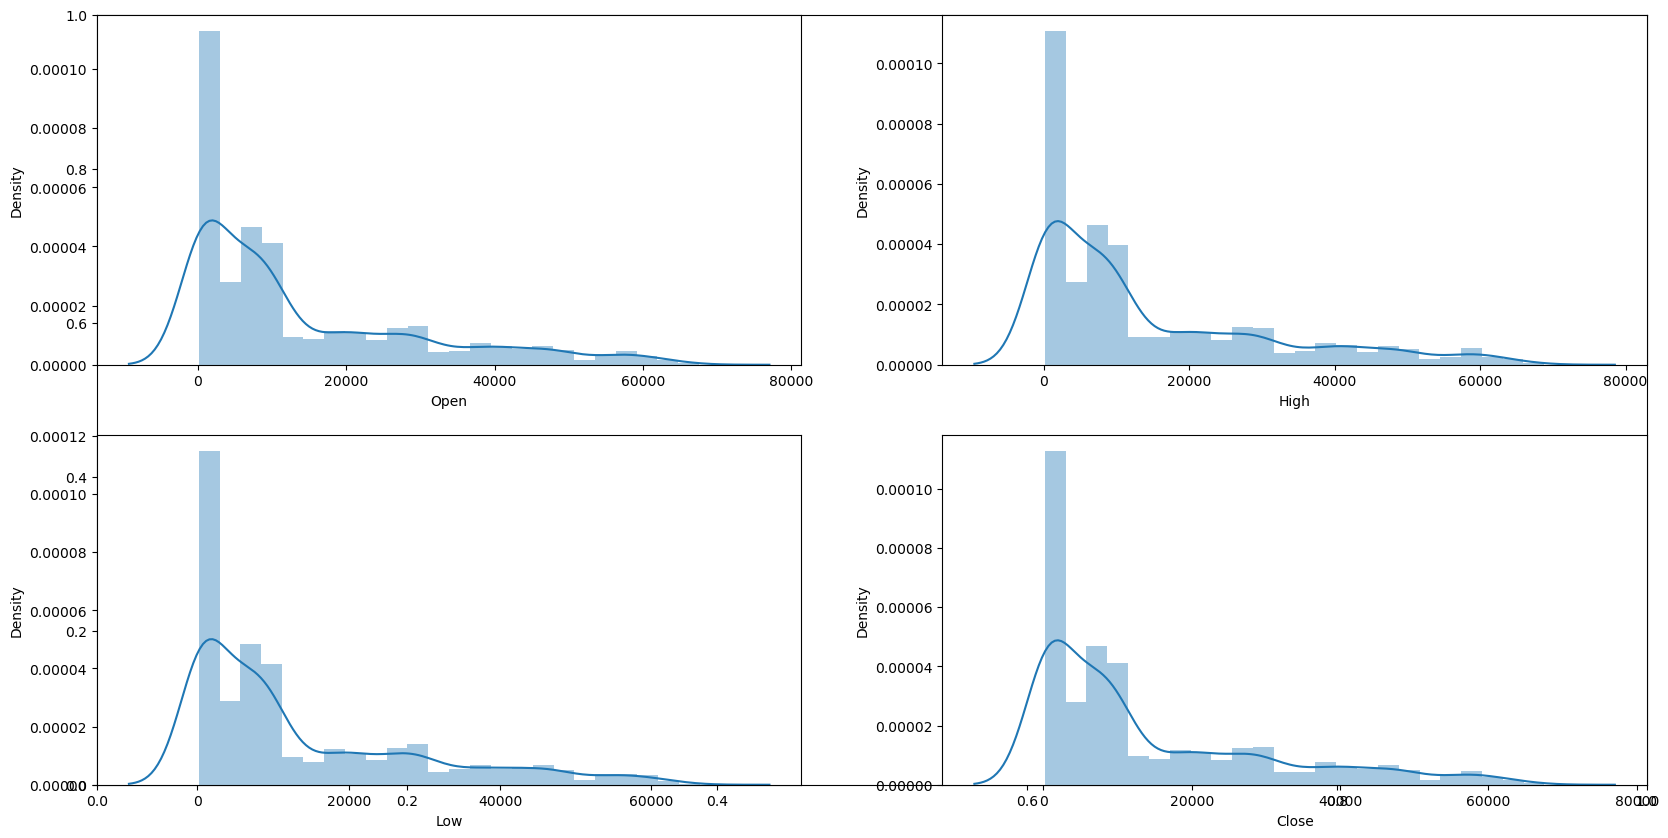

In [6]:
features = ['Open', 'High', 'Low', 'Close']
 
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.distplot(btc_prices[col])
plt.show()

There are so many outliers in the data which means that the prices of the stock have varied hugely in a very short period of time. Let’s check this with the help of a barplot. 

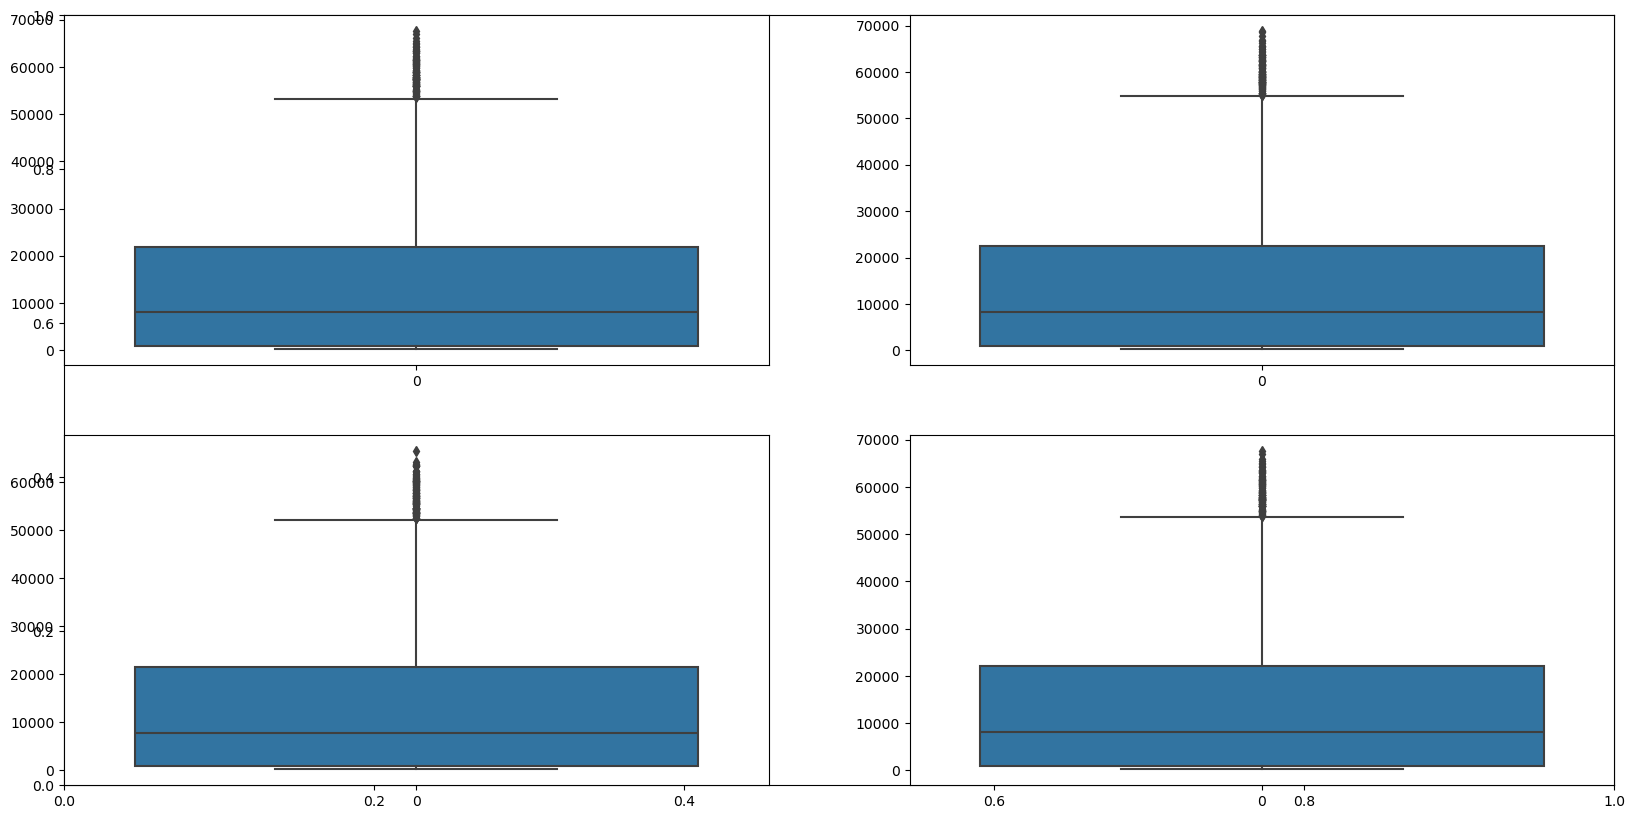

In [7]:
#Barplot
plt.subplots(figsize=(20,10))
for i, col in enumerate(features):
  plt.subplot(2,2,i+1)
  sb.boxplot(btc_prices[col])
plt.show()

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

features = ['Open', 'High', 'Low', 'Close']
target = ['Close']

X = btc_prices[features]
y = btc_prices[target]
 
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Linear Regression model
Hist_linear_model = LinearRegression()
Hist_linear_model.fit(X_train, y_train)

# Make predictions on the test set
Hist_linear_predictions = Hist_linear_model.predict(X_test)

# Evaluate the Linear Regression model
Hist_linear_mae = mean_absolute_error(y_test, Hist_linear_predictions)
Hist_linear_rmse = mean_squared_error(y_test, Hist_linear_predictions, squared=False)

print(f'Linear Regression - Mean Absolute Error: {Hist_linear_mae}')
print(f'Linear Regression - Root Mean Squared Error: {Hist_linear_rmse}')

Linear Regression - Mean Absolute Error: 7.065861573652294e-11
Linear Regression - Root Mean Squared Error: 7.855672847709598e-11


Using this approach, future values are predicted based on Bitcoin's historical data. This method works well in most cases, but what if we’re looking at a time series that is more random than pattern-like? What if a time series is purely speculative and heavily based on current events rather than some rhythmic components?

So if not just some simple pattern, what drives cryptocurrencies prices? Speculation? Innovation? Legal issues? Public opinion? Supply/demand? Bitcoin popularity? 

1. Yahoo Financials API: The top two semiconductor companies used for coin mining AMD and Nvidia stock prices companies used for coin mining

2. It’s also pretty obvious that current events such as legal issues or technological game changers also play a role. Remember when China banned crypto? The price dropped rapidly and everything was in chaos. In an attempt to capture important events like this one, Google News search frequency data is obtained from Pytrends API

In [11]:
# Stock data of AMD and NVDA from Yahoo API
amd = pdr.get_data_yahoo('AMD', start='2014-10-01', end='2023-10-01')
nvda = pdr.get_data_yahoo('NVDA',start='2014-10-01', end='2023-10-01')
amd.info()
nvda.info()
amd.to_csv('amd.csv')
nvda.to_csv('nvda.csv')

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2265 entries, 2014-10-01 to 2023-09-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2265 non-null   float64
 1   High       2265 non-null   float64
 2   Low        2265 non-null   float64
 3   Close      2265 non-null   float64
 4   Adj Close  2265 non-null   float64
 5   Volume     2265 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 123.9 KB
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2265 entries, 2014-10-01 to 2023-09-29
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2265 non-null   float64
 1   High       2265 non-null   float64
 2   Low        2265 non-null   float64
 3   Close      2265 non-null   float64
 4

In [12]:
# Joining data frames
btc_amd_df = pd.merge(btc_prices, amd, on='Date', how='outer')
btc_amd_nvda = pd.merge(btc_amd_df, nvda, on='Date', how='outer')
btc_amd_nvda
btc_amd_nvda.to_csv('btc_amd_nvda_df.csv')

In [13]:
#Filling missing values of AMD and NVDA (i.e Saturday and Sunday values from previous (Friday's) values)
btc_amd_nvda['Close'] = btc_amd_nvda['Close'].fillna(method='ffill')
btc_amd_nvda['Close_y'] = btc_amd_nvda['Close_y'].fillna(method='ffill')

btc_amd_nvda['Open'] = btc_amd_nvda['Open'].fillna(method='ffill')
btc_amd_nvda['Open_y'] = btc_amd_nvda['Open_y'].fillna(method='ffill')

btc_amd_nvda['High'] = btc_amd_nvda['High'].fillna(method='ffill')
btc_amd_nvda['High_y'] = btc_amd_nvda['High_y'].fillna(method='ffill')

btc_amd_nvda['Low'] = btc_amd_nvda['Low'].fillna(method='ffill')
btc_amd_nvda['Low_y'] = btc_amd_nvda['Low_y'].fillna(method='ffill')

btc_amd_nvda['Volume'] = btc_amd_nvda['Volume'].fillna(method='ffill')
btc_amd_nvda['Volume_y'] = btc_amd_nvda['Volume_y'].fillna(method='ffill')

btc_amd_nvda.head(10)

,Open_x,High_x,Low_x,Close_x,Adj Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Adj Close_y,Volume_y,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,,,,,,,,,,,,,
2014-10-01,387.427002,391.378998,380.779999,383.614990,383.614990,26229400,3.39,3.42,3.30,3.35,3.35,33645900.0,4.6200,4.6525,4.5550,4.5675,4.367773,35097600.0
2014-10-02,383.988007,385.497009,372.946014,375.071991,375.071991,21777700,3.37,3.44,3.28,3.39,3.39,27904500.0,4.5600,4.5825,4.4425,4.5475,4.348648,28899600.0
2014-10-03,375.181000,377.695007,357.859009,359.511993,359.511993,30901200,3.43,3.46,3.37,3.40,3.40,16797000.0,4.5750,4.6375,4.5575,4.5575,4.358209,23914000.0
2014-10-04,359.891998,364.487000,325.885986,328.865997,328.865997,47236500,3.43,3.46,3.37,3.40,NaN,16797000.0,4.5750,4.6375,4.5575,4.5575,NaN,23914000.0
2014-10-05,328.915985,341.800995,289.295990,320.510010,320.510010,83308096,3.43,3.46,3.37,3.40,NaN,16797000.0,4.5750,4.6375,4.5575,4.5575,NaN,23914000.0
2014-10-06,320.389008,345.134003,302.559998,330.079010,330.079010,79011800,3.42,3.44,3.30,3.36,3.36,17864800.0,4.5750,4.6125,4.5000,4.5300,4.331912,19903200.0
2014-10-07,330.584015,339.247009,320.481995,336.187012,336.187012,49199900,3.35,3.38,3.28,3.28,3.28,17720600.0,4.5100,4.5550,4.4775,4.4825,4.286489,30189600.0
2014-10-08,336.115997,354.364014,327.187988,352.940002,352.940002,54736300,3.30,3.31,3.18,3.28,3.28,28000000.0,4.4775,4.5875,4.4425,4.5650,4.365383,26017200.0
2014-10-09,352.747986,382.726013,347.687012,365.026001,365.026001,83641104,3.03,3.20,2.94,2.95,2.95,69528900.0,4.5450,4.5500,4.4400,4.4775,4.281708,30695600.0


In [14]:
#Drop Adj Close since its same as Close
btc_amd_nvda = btc_amd_nvda.drop(['Adj Close'], axis=1)
btc_amd_nvda = btc_amd_nvda.drop(['Adj Close_x'], axis=1)
btc_amd_nvda = btc_amd_nvda.drop(['Adj Close_y'], axis=1)
btc_amd_nvda.head(10)

,Open_x,High_x,Low_x,Close_x,Volume_x,Open_y,High_y,Low_y,Close_y,Volume_y,Open,High,Low,Close,Volume
Date,,,,,,,,,,,,,,,
2014-10-01,387.427002,391.378998,380.779999,383.614990,26229400,3.39,3.42,3.30,3.35,33645900.0,4.6200,4.6525,4.5550,4.5675,35097600.0
2014-10-02,383.988007,385.497009,372.946014,375.071991,21777700,3.37,3.44,3.28,3.39,27904500.0,4.5600,4.5825,4.4425,4.5475,28899600.0
2014-10-03,375.181000,377.695007,357.859009,359.511993,30901200,3.43,3.46,3.37,3.40,16797000.0,4.5750,4.6375,4.5575,4.5575,23914000.0
2014-10-04,359.891998,364.487000,325.885986,328.865997,47236500,3.43,3.46,3.37,3.40,16797000.0,4.5750,4.6375,4.5575,4.5575,23914000.0
2014-10-05,328.915985,341.800995,289.295990,320.510010,83308096,3.43,3.46,3.37,3.40,16797000.0,4.5750,4.6375,4.5575,4.5575,23914000.0
2014-10-06,320.389008,345.134003,302.559998,330.079010,79011800,3.42,3.44,3.30,3.36,17864800.0,4.5750,4.6125,4.5000,4.5300,19903200.0
2014-10-07,330.584015,339.247009,320.481995,336.187012,49199900,3.35,3.38,3.28,3.28,17720600.0,4.5100,4.5550,4.4775,4.4825,30189600.0
2014-10-08,336.115997,354.364014,327.187988,352.940002,54736300,3.30,3.31,3.18,3.28,28000000.0,4.4775,4.5875,4.4425,4.5650,26017200.0
2014-10-09,352.747986,382.726013,347.687012,365.026001,83641104,3.03,3.20,2.94,2.95,69528900.0,4.5450,4.5500,4.4400,4.4775,30695600.0


In [15]:
#Rename all column names
btc_amd_nvda.rename(columns={'Open_x': 'Open-BTC', 'High_x': 'High-BTC', 'Low_x': 'Low-BTC', 'Close_x': 'Close-BTC',
                   'Open_y': 'Open-AMD', 'High_y': 'High-AMD', 'Low_y': 'Low-AMD', 'Close_y': 'Close-AMD',
                   'Open': 'Open-NVDA', 'High': 'High-NVDA', 'Low': 'Low-NVDA', 'Close': 'Close-NVDA',
                   }, inplace=True)
btc_amd_nvda.head(10)

,Open-BTC,High-BTC,Low-BTC,Close-BTC,Volume_x,Open-AMD,High-AMD,Low-AMD,Close-AMD,Volume_y,Open-NVDA,High-NVDA,Low-NVDA,Close-NVDA,Volume
Date,,,,,,,,,,,,,,,
2014-10-01,387.427002,391.378998,380.779999,383.614990,26229400,3.39,3.42,3.30,3.35,33645900.0,4.6200,4.6525,4.5550,4.5675,35097600.0
2014-10-02,383.988007,385.497009,372.946014,375.071991,21777700,3.37,3.44,3.28,3.39,27904500.0,4.5600,4.5825,4.4425,4.5475,28899600.0
2014-10-03,375.181000,377.695007,357.859009,359.511993,30901200,3.43,3.46,3.37,3.40,16797000.0,4.5750,4.6375,4.5575,4.5575,23914000.0
2014-10-04,359.891998,364.487000,325.885986,328.865997,47236500,3.43,3.46,3.37,3.40,16797000.0,4.5750,4.6375,4.5575,4.5575,23914000.0
2014-10-05,328.915985,341.800995,289.295990,320.510010,83308096,3.43,3.46,3.37,3.40,16797000.0,4.5750,4.6375,4.5575,4.5575,23914000.0
2014-10-06,320.389008,345.134003,302.559998,330.079010,79011800,3.42,3.44,3.30,3.36,17864800.0,4.5750,4.6125,4.5000,4.5300,19903200.0
2014-10-07,330.584015,339.247009,320.481995,336.187012,49199900,3.35,3.38,3.28,3.28,17720600.0,4.5100,4.5550,4.4775,4.4825,30189600.0
2014-10-08,336.115997,354.364014,327.187988,352.940002,54736300,3.30,3.31,3.18,3.28,28000000.0,4.4775,4.5875,4.4425,4.5650,26017200.0
2014-10-09,352.747986,382.726013,347.687012,365.026001,83641104,3.03,3.20,2.94,2.95,69528900.0,4.5450,4.5500,4.4400,4.4775,30695600.0


In [16]:
# Fetch Google Trends data for 'cryptocurrency', 'bitcoin price', 'gpu mining'
import time
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)

def fetch_google_trends_data():
    try:
        pytrends.build_payload(['cryptocurrency', 'bitcoin price', 'gpu mining'], timeframe='2014-10-01 2023-10-01')
        search_data = pytrends.interest_over_time()
        return search_data
    except Exception as e:
        if '429' in str(e):
            print('TooManyRequestsError: Exceeded rate limit. Backing off...')
            time.sleep(60)  # Wait for 60 seconds
            return fetch_google_trends_data()
        else:
            raise

search_data = fetch_google_trends_data()
search_data

TooManyRequestsError: Exceeded rate limit. Backing off...


,cryptocurrency,bitcoin price,gpu mining,isPartial
date,,,,
2014-10-01,0,1,0,False
2014-11-01,0,1,0,False
2014-12-01,0,1,0,False
2015-01-01,0,1,0,False
2015-02-01,0,1,0,False
...,...,...,...,...
2023-06-01,4,17,0,False
2023-07-01,4,15,0,False
2023-08-01,4,15,0,False


In [17]:
merged_data = pd.merge(btc_amd_nvda, search_data, left_on=btc_amd_nvda.index, right_on=search_data.index)
merged_data.head(10)

,key_0,Open-BTC,High-BTC,Low-BTC,Close-BTC,Volume_x,Open-AMD,High-AMD,Low-AMD,Close-AMD,Volume_y,Open-NVDA,High-NVDA,Low-NVDA,Close-NVDA,Volume,cryptocurrency,bitcoin price,gpu mining,isPartial
0,2014-10-01,387.427002,391.378998,380.779999,383.614990,26229400,3.39,3.42,3.30,3.35,33645900.0,4.6200,4.6525,4.5550,4.5675,35097600.0,0,1,0,False
1,2014-11-01,338.649994,340.528992,321.054993,325.748993,16677200,2.79,2.83,2.75,2.80,14704800.0,4.7800,4.8875,4.7550,4.8850,25631600.0,0,1,0,False
2,2014-12-01,378.248993,383.661987,376.669006,379.244995,11763000,2.77,2.79,2.64,2.67,16025100.0,5.2200,5.2500,5.1375,5.1450,19006000.0,0,1,0,False
3,2015-01-01,320.434998,320.434998,314.002991,314.248993,8036550,2.64,2.70,2.64,2.67,11177900.0,5.1000,5.1275,4.9975,5.0125,16630000.0,0,1,0,False
4,2015-02-01,216.867004,231.574005,212.014999,226.972000,29128500,2.56,2.60,2.51,2.57,12908200.0,4.9100,4.9675,4.7925,4.8000,29820000.0,0,1,0,False
5,2015-03-01,254.283005,261.660004,245.932999,260.201996,25213700,3.07,3.12,3.07,3.11,7150200.0,5.5350,5.5475,5.4950,5.5150,15749200.0,0,1,0,False
6,2015-04-01,244.223007,247.541000,241.160004,247.272003,22877200,2.66,2.75,2.65,2.69,11240500.0,5.2525,5.2700,5.1625,5.2525,33076800.0,0,1,0,False
7,2015-05-01,235.938995,238.966003,232.078995,232.078995,18815300,2.26,2.31,2.25,2.31,11662800.0,5.5950,5.7050,5.5700,5.6875,25696800.0,0,1,0,False
8,2015-06-01,230.233002,231.712997,221.296005,222.925995,26090500,2.29,2.30,2.25,2.25,6803700.0,5.5675,5.6500,5.5325,5.5950,37266000.0,0,1,0,False
9,2015-07-01,263.345001,265.171997,255.774002,258.621002,27029800,2.47,2.48,2.36,2.42,19375000.0,5.1525,5.2250,5.0550,5.1000,30289200.0,0,1,0,False


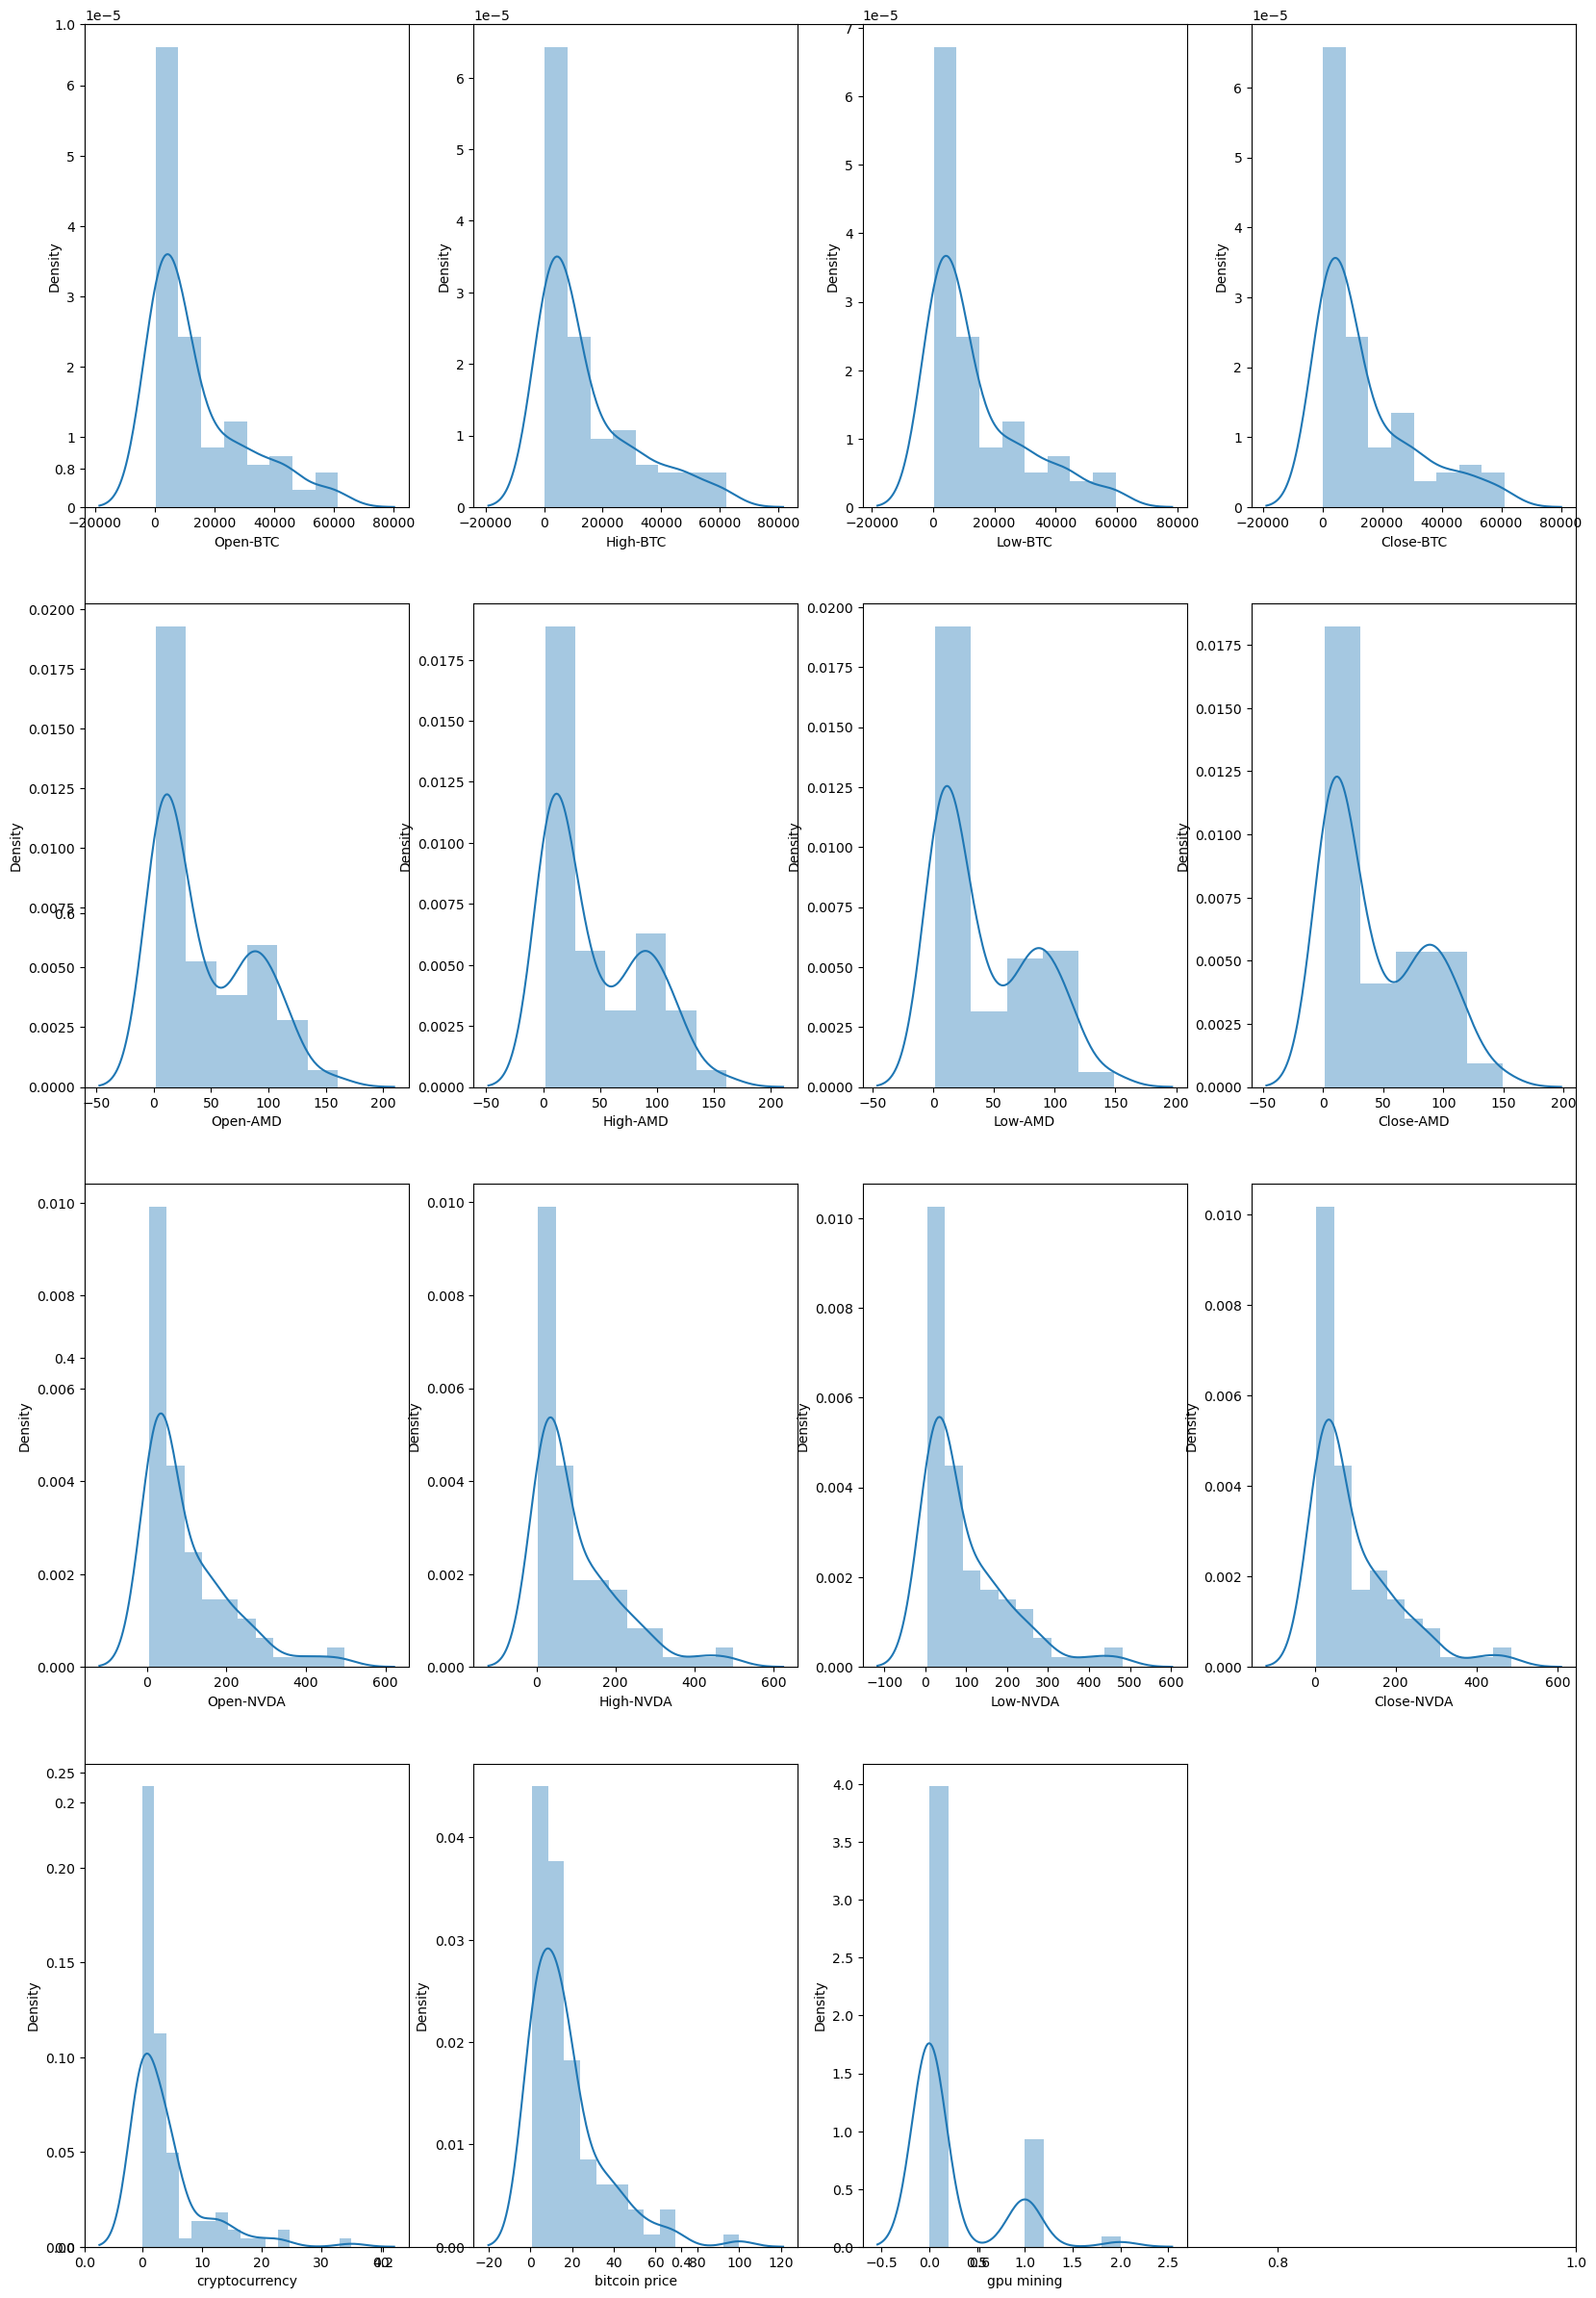

In [18]:
features = ['Open-BTC', 'High-BTC', 'Low-BTC', 'Close-BTC','Open-AMD', 'High-AMD', 'Low-AMD', 'Close-AMD',
           'Open-NVDA', 'High-NVDA', 'Low-NVDA', 'Close-NVDA',
           'cryptocurrency', 'bitcoin price', 'gpu mining']
 
plt.subplots(figsize=(20,30))
for i, col in enumerate(features):
  plt.subplot(4,4,i+1)
  sb.distplot(merged_data[col])
plt.show()

In [19]:
target = 'Close-BTC'

# Model - Linear Regression

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
X = merged_data[features]
y = merged_data[target]

# Split the data into training and testing sets in 80%-20% ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Linear Regression model
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Make predictions on the test set
linear_predictions = linear_model.predict(X_test)

# Evaluate the Linear Regression model
linear_mae = mean_absolute_error(y_test, linear_predictions)
linear_rmse = mean_squared_error(y_test, linear_predictions, squared=False)

print(f'Linear Regression - Mean Absolute Error: {linear_mae}')
print(f'Linear Regression - Root Mean Squared Error: {linear_rmse}')

Linear Regression - Mean Absolute Error: 1.9843520765954796e-12
Linear Regression - Root Mean Squared Error: 3.799744938930187e-12


# Model - Gradient Boost

In [21]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_predictions = xgb_model.predict(X_test)

# Evaluate the XGBoost model
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)

print(f'XGBoost - Mean Absolute Error: {xgb_mae}')
print(f'XGBoost - Root Mean Squared Error: {xgb_rmse}')

XGBoost - Mean Absolute Error: 3350.5984996448865
XGBoost - Root Mean Squared Error: 4339.152123908364


# Model - KNN

In [22]:
# k-NN model
from sklearn.neighbors import KNeighborsRegressor
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_predictions = knn_model.predict(X_test)
knn_mae = mean_absolute_error(y_test, knn_predictions)
knn_rmse = mean_squared_error(y_test, knn_predictions, squared=False)
print(f'k-NN - Mean Absolute Error: {knn_mae}')
print(f'k-NN - Root Mean Squared Error: {knn_rmse}')

k-NN - Mean Absolute Error: 2726.3375355113635
k-NN - Root Mean Squared Error: 3212.706195707221


# Model - Decision Tree

In [23]:
# Decision Trees model
from sklearn.tree import DecisionTreeRegressor
decision_tree_model = DecisionTreeRegressor()
decision_tree_model.fit(X_train, y_train)
decision_tree_predictions = decision_tree_model.predict(X_test)
decision_tree_mae = mean_absolute_error(y_test, decision_tree_predictions)
decision_tree_rmse = mean_squared_error(y_test, decision_tree_predictions, squared=False)
print(f'Decision Trees - Mean Absolute Error: {decision_tree_mae}')
print(f'Decision Trees - Root Mean Squared Error: {decision_tree_rmse}')

Decision Trees - Mean Absolute Error: 3496.2944779829545
Decision Trees - Root Mean Squared Error: 4481.751087254244


# Model - Neural Network: Sequential

In [24]:
# Neural Networks model
from keras.models import Sequential
from keras.layers import Activation, Dense
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=len(features), activation='relu'))
nn_model.add(Dense(1, activation='linear'))
nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)
nn_predictions = nn_model.predict(X_test)
nn_mae = mean_absolute_error(y_test, nn_predictions)
nn_rmse = mean_squared_error(y_test, nn_predictions, squared=False)
print(f'Neural Networks - Mean Absolute Error: {nn_mae}')
print(f'Neural Networks - Root Mean Squared Error: {nn_rmse}')

2023-12-12 16:29:06.784390: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/100


2023-12-12 16:29:10.018984: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


3/3 [==============================] - 0s 2ms/step - loss: 397813376.0000
Epoch 2/100
3/3 [==============================] - 0s 1ms/step - loss: 349335968.0000
Epoch 3/100
3/3 [==============================] - 0s 2ms/step - loss: 311748832.0000
Epoch 4/100
3/3 [==============================] - 0s 954us/step - loss: 271109664.0000
Epoch 5/100
3/3 [==============================] - 0s 1ms/step - loss: 235110464.0000
Epoch 6/100
3/3 [==============================] - 0s 1ms/step - loss: 205549616.0000
Epoch 7/100
3/3 [==============================] - 0s 1ms/step - loss: 171187408.0000
Epoch 8/100
3/3 [==============================] - 0s 1ms/step - loss: 147714336.0000
Epoch 9/100
3/3 [==============================] - 0s 2ms/step - loss: 123842344.0000
Epoch 10/100
3/3 [==============================] - 0s 1ms/step - loss: 102419024.0000
Epoch 11/100
3/3 [==============================] - 0s 1ms/step - loss: 84641768.0000
Epoch 12/100
3/3 [==============================] - 0s 1ms/step

3/3 [==============================] - 0s 2ms/step - loss: 108089.6016
Epoch 99/100
3/3 [==============================] - 0s 1ms/step - loss: 108104.2656
Epoch 100/100
1/1 [==============================] - 0s 44ms/step
Neural Networks - Mean Absolute Error: 347.6637073863636
Neural Networks - Root Mean Squared Error: 473.03949314707967


Training Loss: The training loss after 100 epochs is 108401, indicating that the model is still not capturing the patterns in the training data very well.
The Mean Absolute Error (MAE) is 347.66, and the Root Mean Squared Error (RMSE) is 473.03 on the test set.

So we will try improving the neural network model's training performance with by 1. Adding Dropout for Regularization and 2. Adjust Learning Rate with a Learning Rate Scheduler

In [25]:
#Add Dropout for Regularization
#Randomly drops neurons during training, 
#preventing the model from relying too heavily on specific neurons and improving generalization.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Create a Sequential model with Dropout layers
nnd_model = Sequential()
nnd_model.add(Dense(64, input_dim=len(features), activation='relu'))
nnd_model.add(Dropout(0.5))
nnd_model.add(Dense(1, activation='linear'))

# Compile the model
nnd_model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
nnd_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
nnd_predictions = nnd_model.predict(X_test)
nnd_mae = mean_absolute_error(y_test, nnd_predictions)
nnd_rmse = mean_squared_error(y_test, nnd_predictions, squared=False)
print(f'Neural Networks with dropout - Mean Absolute Error: {nnd_mae}')
print(f'Neural Networks with dropout - Root Mean Squared Error: {nnd_rmse}')


Epoch 1/100
3/3 [==============================] - 0s 58ms/step - loss: 28122596.0000 - val_loss: 1026880256.0000
Epoch 2/100
3/3 [==============================] - 0s 8ms/step - loss: 26416558.0000 - val_loss: 914776000.0000
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 18089642.0000 - val_loss: 809260992.0000
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 15325459.0000 - val_loss: 712950208.0000
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 19343614.0000 - val_loss: 620079040.0000
Epoch 6/100
3/3 [==============================] - 0s 8ms/step - loss: 13247903.0000 - val_loss: 537638400.0000
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 13938120.0000 - val_loss: 463114400.0000
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 9555245.0000 - val_loss: 399293408.0000
Epoch 9/100
3/3 [==============================] - 0s 9ms/step - loss: 9913813.0000 - val_loss: 3416554

Epoch 75/100
3/3 [==============================] - 0s 8ms/step - loss: 1609037.8750 - val_loss: 8052930.0000
Epoch 76/100
3/3 [==============================] - 0s 9ms/step - loss: 3186262.0000 - val_loss: 9832844.0000
Epoch 77/100
3/3 [==============================] - 0s 9ms/step - loss: 1992479.5000 - val_loss: 11807924.0000
Epoch 78/100
3/3 [==============================] - 0s 9ms/step - loss: 3401462.7500 - val_loss: 13274043.0000
Epoch 79/100
3/3 [==============================] - 0s 9ms/step - loss: 1932199.0000 - val_loss: 13944023.0000
Epoch 80/100
3/3 [==============================] - 0s 9ms/step - loss: 2518559.2500 - val_loss: 13528343.0000
Epoch 81/100
3/3 [==============================] - 0s 9ms/step - loss: 2095091.7500 - val_loss: 13327106.0000
Epoch 82/100
3/3 [==============================] - 0s 9ms/step - loss: 2454393.5000 - val_loss: 13437894.0000
Epoch 83/100
3/3 [==============================] - 0s 9ms/step - loss: 2326967.2500 - val_loss: 13159745.0000
Epo

In [34]:
#Adjust Learning Rate with a Learning Rate Scheduler
#Learning rate schedules adaptively adjust the learning rate during training, 
#which can help the model converge more effectively.
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define a learning rate scheduler
def lr_scheduler(epoch, lr):
    if epoch < 50:
        return lr  # Keep the initial learning rate for the first 50 epochs
    else:
        return lr * 0.95  # Decrease the learning rate by 5% after 50 epochs

# Create a Sequential model
nnl_model = Sequential()
nnl_model.add(Dense(64, input_dim=len(features), activation='relu'))
nnl_model.add(Dense(1, activation='linear'))

# Compile the model with the Adam optimizer and the learning rate scheduler
adam_optimizer = Adam(learning_rate=0.001)  # Set an initial learning rate
nnl_model.compile(optimizer=adam_optimizer, loss='mean_squared_error', metrics=['accuracy'])

# Train the model with the learning rate scheduler
nnl_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                       callbacks=[LearningRateScheduler(lr_scheduler)], verbose=1)
nnl_predictions = nnl_model.predict(X_test)
nnl_mae = mean_absolute_error(y_test, nnl_predictions)
nnl_rmse = mean_squared_error(y_test, nnl_predictions, squared=False)
print(f'Neural Networks with learning rate - Mean Absolute Error: {nnl_mae}')
print(f'Neural Networks with learning rate - Root Mean Squared Error: {nnl_rmse}')


Epoch 1/100
3/3 [==============================] - 0s 39ms/step - loss: 58418352.0000 - accuracy: 0.0000e+00 - val_loss: 2364822528.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 51560380.0000 - accuracy: 0.0000e+00 - val_loss: 2088784768.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 3/100
3/3 [==============================] - 0s 10ms/step - loss: 45405012.0000 - accuracy: 0.0000e+00 - val_loss: 1825646464.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 39793384.0000 - accuracy: 0.0000e+00 - val_loss: 1580217088.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 33974436.0000 - accuracy: 0.0000e+00 - val_loss: 1361995136.0000 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 29357150.0000 - accuracy: 0.0000e+00 - val_lo

3/3 [==============================] - 0s 9ms/step - loss: 8663.4941 - accuracy: 0.0000e+00 - val_loss: 510249.3750 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 49/100
3/3 [==============================] - 0s 9ms/step - loss: 8646.8203 - accuracy: 0.0000e+00 - val_loss: 520592.4375 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 50/100
3/3 [==============================] - 0s 9ms/step - loss: 8729.4990 - accuracy: 0.0000e+00 - val_loss: 529430.4375 - val_accuracy: 0.0000e+00 - lr: 0.0010
Epoch 51/100
3/3 [==============================] - 0s 9ms/step - loss: 8726.2520 - accuracy: 0.0000e+00 - val_loss: 529711.8125 - val_accuracy: 0.0000e+00 - lr: 9.5000e-04
Epoch 52/100
3/3 [==============================] - 0s 9ms/step - loss: 8725.1650 - accuracy: 0.0000e+00 - val_loss: 522706.7812 - val_accuracy: 0.0000e+00 - lr: 9.0250e-04
Epoch 53/100
3/3 [==============================] - 0s 9ms/step - loss: 8679.5078 - accuracy: 0.0000e+00 - val_loss: 514919.4375 - val_accuracy: 0.0000e+00 - lr

3/3 [==============================] - 0s 9ms/step - loss: 8647.6436 - accuracy: 0.0000e+00 - val_loss: 481630.2812 - val_accuracy: 0.0000e+00 - lr: 9.9440e-05
Epoch 96/100
3/3 [==============================] - 0s 9ms/step - loss: 8649.4307 - accuracy: 0.0000e+00 - val_loss: 481230.2188 - val_accuracy: 0.0000e+00 - lr: 9.4468e-05
Epoch 97/100
3/3 [==============================] - 0s 9ms/step - loss: 8648.4502 - accuracy: 0.0000e+00 - val_loss: 481210.3750 - val_accuracy: 0.0000e+00 - lr: 8.9745e-05
Epoch 98/100
3/3 [==============================] - 0s 9ms/step - loss: 8648.3311 - accuracy: 0.0000e+00 - val_loss: 481382.8438 - val_accuracy: 0.0000e+00 - lr: 8.5258e-05
Epoch 99/100
3/3 [==============================] - 0s 9ms/step - loss: 8647.6211 - accuracy: 0.0000e+00 - val_loss: 481613.6562 - val_accuracy: 0.0000e+00 - lr: 8.0995e-05
Epoch 100/100
1/1 [==============================] - 0s 31ms/step
Neural Networks with learning rate - Mean Absolute Error: 305.82057883522725
Neura

# Additional Improvements:

In [114]:
#Cross validation on Logistic Regression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer


scorer = make_scorer(mean_absolute_error, greater_is_better=False)

cv_scores = cross_val_score(linear_model, X, y, cv=5, scoring=scorer)

print("Cross-Validation Scores:", cv_scores)
print("Mean CV Score:", np.mean(cv_scores))


Cross-Validation Scores: [-1.05547894e-11 -1.44692339e-11 -1.50686736e-11 -3.04897271e-11
 -2.56390887e-11]
Mean CV Score: -1.9244302544015607e-11


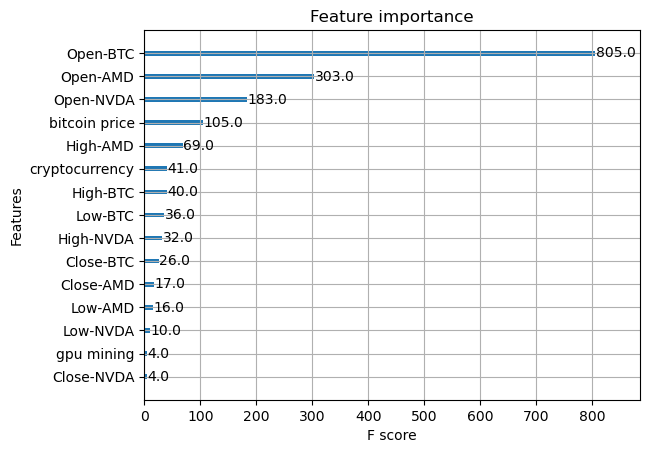

In [115]:
import xgboost as xgb
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Plot feature importance
plot_importance(xgb_model)
plt.show()